<a href="https://colab.research.google.com/github/alexeyphilippov/NN_Grid_search/blob/master/earthquake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -U -q PyDrive
import os
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

    100% |████████████████████████████████| 993kB 23.6MB/s 


In [6]:
link_to_both = 'https://drive.google.com/open?id=1OHFGBUQJKMB9eYChhuWiybI75CEmSHgp'
id_to_both = '1OHFGBUQJKMB9eYChhuWiybI75CEmSHgp'
local_download_path = os.path.expanduser('~/data')
try:
  os.makedirs(local_download_path)
except: pass

file_names = []
for file in drive.ListFile(
    {'q': "'1OHFGBUQJKMB9eYChhuWiybI75CEmSHgp' in parents"}).GetList():
  fname = os.path.join(local_download_path, file['title'])
  f_ = drive.CreateFile({'id': file['id']})
  f_.GetContentFile(fname)
  file_names.append(file['id'])
 
print('Amount of pictures: ', len(file_names))

Amount of pictures:  9485


In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import shuffle
import matplotlib.image as mpimg
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler


In [9]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [0]:
train_capacity = 8040
test_capacity = 1400
class EarthQuakeDataset(Dataset):

    def __init__(self, train:bool, both_path, transform=None):
        """
        Args:
            pos_dir (string): Directory with all the images with earthquakes.
            neg_dir (string): Directory with all the images without earthquakes.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        
        id = '1d8JBl_qAPf7eMzGvQp9jK1fJxNq-P3Wy' 
        downloaded = drive.CreateFile({'id':id}) 
        downloaded.GetContentFile('image_map.csv')  
        self.map_ = pd.read_csv('image_map.csv', sep = '±')
        
        self.map_.path = self.map_.path.apply(lambda x: both_path+'/'+x)
        
        if train:
            self.img_paths = self.map_.path[:train_capacity]
            self.labels = self.map_.label[:train_capacity]
        elif train != True:
            self.img_paths = self.map_.path[train_capacity:train_capacity+test_capacity].tolist()
            self.labels = self.map_.label[train_capacity:train_capacity+test_capacity].tolist()
        else:
            raise Exception('Parameter train must be set bull')
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        image = mpimg.imread(self.img_paths[idx])[:-1, :-1]
        label = self.labels[idx]

        return image, label

In [11]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))])
train_set = EarthQuakeDataset(train = True, both_path = local_download_path, transform = transform)
test_set = EarthQuakeDataset(train = False, both_path = local_download_path, transform = transform)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.


In [0]:
#DataLoader takes in a dataset and a sampler for loading (num_workers deals with system level memory) 
def get_train_loader(batch_size):
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2)
    return(train_loader)

In [0]:
#Test loader has constant batch sizes, so we can define it directly
test_loader = torch.utils.data.DataLoader(test_set, batch_size=20, num_workers=2)

In [0]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    
    #Loss function
    loss = torch.nn.BCELoss()
    
    #Optimizer
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    
    return(loss, optimizer)

In [0]:
from torch.autograd import Variable
import torch.nn.functional as F

class SimpleCNN(torch.nn.Module):
    
    #Our batch shape for input x is (1, 82, 82)
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        #Input channels = 1, output channels = 18
        self.conv1 = torch.nn.Conv2d(1, 18, kernel_size=3, stride=1, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        #4608 input features, 64 output features (see sizing flow below)
        self.fc1 = torch.nn.Linear(18 * 41 * 41, 64)
        
        self.bn1 = torch.nn.BatchNorm1d(64)
        
        #64 input features, 10 output features for our 10 defined classes
        self.dropout1 = torch.nn.Dropout(p = 0.9)
        self.fc2 = torch.nn.Linear(64, 1)
        
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x):
        
        #Computes the activation of the first convolution
        #Size changes from (1, 82, 82) to (18, 82, 82)
        x = F.relu(self.conv1(x))
        
        #Size changes from (18, 82, 82) to (18, 41, 41)
        x = self.pool(x)
        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 41, 41) to (1, 30258)
        #Recall that the -1 infers this dimension from the other given dimension
        x = x.view(-1, 18 * 41 *41)
        
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 30258) to (1, 64)
        x = F.relu(self.bn1(self.fc1(x)))
        
        #Computes the second fully connected layer (activation applied later)
        #Size changes from (1, 64) to (1, 20)
        x = self.fc2(self.dropout1(x))
        
        x = self.sigmoid(x)
        return(x)

In [0]:
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def trainNet(net, batch_size, n_epochs, learning_rate):
    
    #Print all of the hyperparameters of the training iteration:
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    #Get training data
    train_loader = get_train_loader(batch_size)
    n_batches = len(train_loader)
    
    #Create our loss and optimizer functions
    loss, optimizer = createLossAndOptimizer(net, learning_rate)
    
    #Time for printing
    training_start_time = time.time()
    
    #Loop for n_epochs
    test_losses = []
    train_losses = []
    for epoch in range(n_epochs):
        
        running_loss = 0.0
        print_every = n_batches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, data in enumerate(train_loader):
            
            #Get inputs
            inputs, labels = data
            inputs = inputs.view((inputs.shape[0],1, inputs.shape[2], inputs.shape[2]))
            
            #Wrap them in a Variable object
            inputs, labels = Variable(inputs), Variable(labels.type(torch.FloatTensor))
            
            #Set the parameter gradients to zero
            optimizer.zero_grad()
            
            #Forward pass, backward pass, optimize
            inputs = inputs.to(device)
            outputs = net(inputs)
            labels = labels.to(device)
            outputs = outputs.to(device)
            loss_size = loss(outputs, labels)
            loss_size.backward()
            optimizer.step()
            
            #Print statistics
            running_loss += loss_size.data.item()
            total_train_loss += loss_size.data.item()
            
            #Print every 10th batch of an epoch
            if (i + 1) % (print_every + 1) == 0:
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch+1, int(100 * (i+1) / n_batches), running_loss / print_every, time.time() - start_time))
                #Reset running loss and time
                running_loss = 0.0
                start_time = time.time()
            
        train_losses.append(total_train_loss/len(train_loader))
        #At the end of the epoch, do a pass on the validation set
        total_test_loss = 0
        for inputs, labels in test_loader:
            
            #Wrap tensors in Variables
            inputs = inputs.view((inputs.shape[0],1, inputs.shape[2], inputs.shape[2]))
            inputs, labels = Variable(inputs), Variable(labels.type(torch.FloatTensor))
            
            #Forward pass
            inputs = inputs.to(device)
            labels = labels.to(device)
            test_outputs = net(inputs)
            test_outputs = test_outputs.to(device)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
            
        print("Test loss = {:.2f}".format(total_test_loss / len(test_loader)))
        test_losses.append(total_test_loss / len(test_loader))
        
    print("Training finished, took {:.2f}s".format(time.time() - training_start_time))
    plt.plot(range(len(train_losses)), train_losses)
    plt.plot(range(len(train_losses)), test_losses)
    plt.show()
    return train_losses, test_losses, optimizer

===== HYPERPARAMETERS =====
batch_size= 20
epochs= 20
learning_rate= 0.0001


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2016: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Epoch 1, 10% 	 train_loss: 0.67 took: 0.50s
Epoch 1, 20% 	 train_loss: 0.58 took: 0.36s
Epoch 1, 30% 	 train_loss: 0.57 took: 0.34s
Epoch 1, 40% 	 train_loss: 0.54 took: 0.35s
Epoch 1, 50% 	 train_loss: 0.52 took: 0.39s
Epoch 1, 61% 	 train_loss: 0.52 took: 0.42s
Epoch 1, 71% 	 train_loss: 0.51 took: 0.42s
Epoch 1, 81% 	 train_loss: 0.49 took: 0.43s
Epoch 1, 91% 	 train_loss: 0.50 took: 0.41s
Test loss = 0.46
Epoch 2, 10% 	 train_loss: 0.48 took: 0.53s
Epoch 2, 20% 	 train_loss: 0.47 took: 0.42s
Epoch 2, 30% 	 train_loss: 0.45 took: 0.42s
Epoch 2, 40% 	 train_loss: 0.45 took: 0.43s
Epoch 2, 50% 	 train_loss: 0.45 took: 0.42s
Epoch 2, 61% 	 train_loss: 0.45 took: 0.43s
Epoch 2, 71% 	 train_loss: 0.45 took: 0.42s
Epoch 2, 81% 	 train_loss: 0.44 took: 0.42s
Epoch 2, 91% 	 train_loss: 0.44 took: 0.43s
Test loss = 0.41
Epoch 3, 10% 	 train_loss: 0.43 took: 0.52s
Epoch 3, 20% 	 train_loss: 0.40 took: 0.42s
Epoch 3, 30% 	 train_loss: 0.42 took: 0.42s
Epoch 3, 40% 	 train_loss: 0.40 took: 0.42

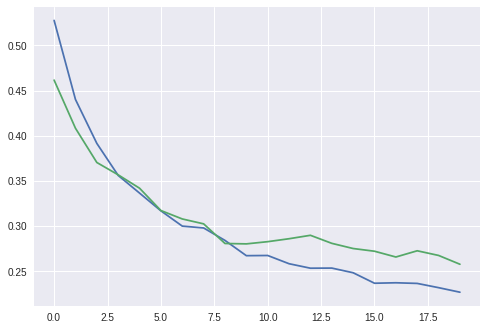

In [49]:
CNN = SimpleCNN()
CNN.to(device)
tr, te ,optim = trainNet(CNN, batch_size=80, n_epochs=150, learning_rate=0.0001)

In [42]:
id = '1d8JBl_qAPf7eMzGvQp9jK1fJxNq-P3Wy' 
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('image_map.csv')  
map_for_testing = pd.read_csv('image_map.csv', sep = '±')
map_for_testing.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


,path,label
0,trace-628-p0-2016-11-25_05-00-00_338620-y.png,1
1,mat_trace-624-2016-11-27_13-00-00_sample_34423...,0
2,mat_trace-624-2016-11-24_04-00-00_sample_11526...,0
3,mat_trace-624-2016-11-07_09-00-00_sample_12652...,0
4,mat_trace-620-2016-11-11_12-00-00_sample_11355...,0


Image of an earthquake


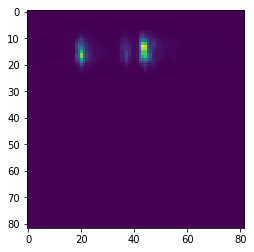

In [0]:
import matplotlib.pyplot as plt
rand_idx = np.random.randint(len(map_for_testing))
path_for_random_img = local_download_path+'/'+map_for_testing.path[rand_idx]
label_for_random_img = map_for_testing.label[rand_idx]

# Need to crop an image from shape (83, 83) to (82, 82) because of convolutional layers
image = mpimg.imread(path_for_random_img)[:-1, :-1]
if label_for_random_img == 0:
    print("=" * 30)
    print('Image of non-earthquake')
    print("=" * 30)
elif label_for_random_img == 1:
    print("=" * 30)
    print('Image of an earthquake')
    print("=" * 30)
plt.imshow(image)

image = torch.tensor(image)
image = image.view((1,1, image.shape[1], image.shape[1]))
res = CNN(image)


In [63]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model_save_name = 'classifier.pt'
path = F"/content/gdrive/My Drive/Python_for_colab/quake/models/{model_save_name}" 
torch.save(CNN.state_dict(), path)